In [1]:
from time import time
from GeneralisedWick import *
import CC, texify
import pickle

fockTensor = Tensor("f", ['g'], ['g'])
h2Tensor = Tensor("v", ['g', 'g'], ['g', 'g'])

fockTensor.getAllDiagramsGeneral()
h2Tensor.getAllDiagramsGeneral()

t2Tensor = Tensor("{t_{2}}", ['p', 'p'], ['h', 'h'])

normalOrderedHamiltonian = sum(fockTensor.diagrams) + (1. / 2.) * sum(h2Tensor.diagrams)
BCH = CC.BCHSimilarityTransform(normalOrderedHamiltonian, 0.5 * t2Tensor, 2)

In [2]:
import networkx as nx
from networkx.algorithms import isomorphism

In [3]:
CCDEnergy = evaluateWickFree(BCH, True)

In [4]:
print(CCDEnergy)

1.0 * v_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}
 + -0.5 * v_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{1}h_{0}}
 + -0.5 * v_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{0}h_{1}}
 + 1.0 * v_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{1}}


In [5]:
class node:
    def __init__(self, annihilationIndex, creationIndex):
        self.inIndex = annihilationIndex
        self.outIndex = creationIndex
        self.inContracted = False
        self.outContracted = False

In [6]:
def genNodes(term):
    for vertex in term.vertexList:
        vertex.nodes = []
        for i in range(vertex.excitationRank):
            vertex.nodes.append(node(vertex.upperIndices[i], vertex.lowerIndices[i]))

In [7]:
def getGraph_old(term):
    termGraph = nx.DiGraph()
    genNodes(term)
    for vertex in term.vertexList:
        for n in vertex.nodes:
            termGraph.add_node(n)
        for nodePair in itertools.combinations(vertex.nodes, 2):
            termGraph.add_edge(nodePair[0], nodePair[1])
            termGraph.add_edge(nodePair[1], nodePair[0])
    for v1, vertex1 in enumerate(term.vertexList):
        for v2, vertex2 in enumerate(term.vertexList):
            for node1 in vertex1.nodes:
                for node2 in vertex2.nodes:
                    if node1.outIndex == node2.inIndex:
                        termGraph.add_edge(node1, node2)
    return termGraph

In [8]:
def getGraph(term):
    termGraph = nx.DiGraph()
    genNodes(term)
    for v1, vertex1 in enumerate(term.vertexList):
        termGraph.add_nodes_from(vertex1.nodes, vertex=v1, freeOutType="", freeInType="")
        termGraph.add_edges_from(itertools.permutations(vertex1.nodes, 2), connection="interaction")
        for v2, vertex2 in enumerate(term.vertexList):
            for node1 in vertex1.nodes:
                for node2 in vertex2.nodes:
                    if node1.outIndex == node2.inIndex:
                        node1.outContracted = True
                        node2.inContracted = True
                        termGraph.add_edge(node1, node2, connection="propagation")
        for node1 in vertex1.nodes:
            if not node1.outContracted:
                if node1.outIndex.occupiedInVacuum:
                    termGraph.nodes[node1]["freeOutType"]="h"
                else:
                    termGraph.nodes[node1]["freeOutType"]="p"
            if not node1.inContracted:
                if node1.inIndex.occupiedInVacuum:
                    termGraph.nodes[node1]["freeInType"]="h"
                else:
                    termGraph.nodes[node1]["freeInType"]="p"
    return termGraph

In [9]:
direct = getGraph(CCDEnergy.summandList[0])
exchange = getGraph(CCDEnergy.summandList[1])

In [10]:
layout = nx.multipartite_layout(direct, "vertex", "horizontal")

In [11]:
direct.edges

OutEdgeView([(<__main__.node object at 0x7febd867ee10>, <__main__.node object at 0x7febd867ec50>), (<__main__.node object at 0x7febd867ee10>, <__main__.node object at 0x7febd867eeb8>), (<__main__.node object at 0x7febd867ec50>, <__main__.node object at 0x7febd867ee10>), (<__main__.node object at 0x7febd867ec50>, <__main__.node object at 0x7febd867efd0>), (<__main__.node object at 0x7febd867eeb8>, <__main__.node object at 0x7febd867efd0>), (<__main__.node object at 0x7febd867eeb8>, <__main__.node object at 0x7febd867ee10>), (<__main__.node object at 0x7febd867efd0>, <__main__.node object at 0x7febd867eeb8>), (<__main__.node object at 0x7febd867efd0>, <__main__.node object at 0x7febd867ec50>)])

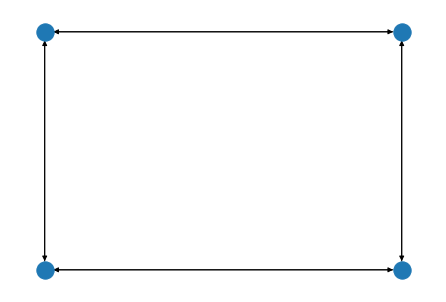

In [12]:
nx.draw(direct, nx.multipartite_layout(direct, "vertex", "horizontal"))

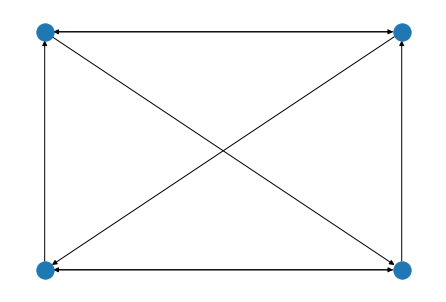

In [13]:
nx.draw(exchange, nx.multipartite_layout(exchange, "vertex", "horizontal"))

In [14]:
direct1 = getGraph(CCDEnergy.summandList[3])
exchange1 = getGraph(CCDEnergy.summandList[2])

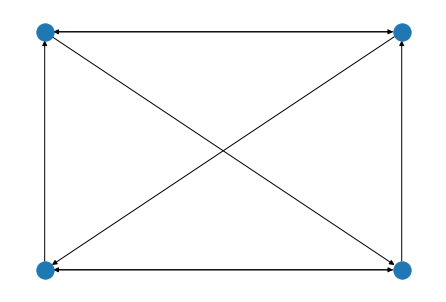

In [15]:
nx.draw(exchange1, nx.multipartite_layout(exchange1, "vertex", "horizontal"))

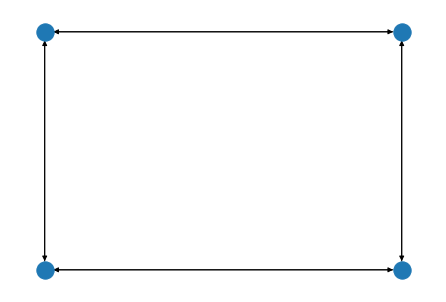

In [16]:
nx.draw(direct1, nx.multipartite_layout(direct1, "vertex", "horizontal"))

In [17]:
print(nx.is_isomorphic(direct, direct))
print(nx.is_isomorphic(direct, exchange))
print(nx.is_isomorphic(direct, exchange1))
print(nx.is_isomorphic(direct, direct1))
print(nx.is_isomorphic(exchange, direct))
print(nx.is_isomorphic(exchange, exchange))
print(nx.is_isomorphic(exchange, exchange1))
print(nx.is_isomorphic(exchange, direct1))
print(nx.is_isomorphic(exchange1, direct))
print(nx.is_isomorphic(exchange1, exchange))
print(nx.is_isomorphic(exchange1, exchange1))
print(nx.is_isomorphic(exchange, direct1))
print(nx.is_isomorphic(direct1, direct))
print(nx.is_isomorphic(direct1, exchange))
print(nx.is_isomorphic(direct1, exchange1))
print(nx.is_isomorphic(direct1, direct1))

True
False
False
True
False
True
True
False
False
True
True
False
True
False
False
True


In [18]:
def isProportional(term1, term2):
    term1Graph = getGraph(term1)
    term2Graph = getGraph(term2)
    DiGM = isomorphism.DiGraphMatcher(term1Graph, term2Graph)
    return (term1.tensorList == term2.tensorList) and DiGM.is_isomorphic() and all([DiGM.semantic_feasibility(DiGM.mapping[n], n) for n in DiGM.mapping.keys()])

In [19]:
def collectEquation(equation):
    collectedEquation = TensorSum([])
    for summand in equation.summandList:
        included = False
        for uniqueSummand in collectedEquation.summandList:
            if isProportional(summand, uniqueSummand):
                included = True
                uniqueSummand.prefactor += summand.prefactor
        if not included:
            collectedEquation.summandList.append(copy(summand))
    return collectedEquation

In [20]:
print(CCDEnergy)

1.0 * v_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}
 + -0.5 * v_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{1}h_{0}}
 + -0.5 * v_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{0}h_{1}}
 + 1.0 * v_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{1}}


In [21]:
print(collectEquation(CCDEnergy))

2.0 * v_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}
 + -1.0 * v_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{1}h_{0}}


In [22]:
CCDAmplitudes = evaluateWickFree(BCH, True, (['p', 'p'], ['h', 'h']))

In [23]:
len(CCDAmplitudes.summandList)

708

In [24]:
print(CCDAmplitudes)

0.5 * v_{p_{0}p_{1}}^{h_{0}h_{1}}
 + 0.5 * v_{p_{0}p_{1}}^{h_{0}h_{1}}
 + 0.5 * v_{p_{0}p_{1}}^{h_{0}h_{1}}
 + 0.5 * v_{p_{0}p_{1}}^{h_{0}h_{1}}
 + -0.5 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{3}}
 + 0.5 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + 0.5 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + -0.5 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{3}}
 + -0.5 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{3}}
 + 0.5 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + -0.5 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{3}}
 + 0.5 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + -0.5 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{1}}
 + 0.5 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{1}p_{3}}^{h_{0}h_{1}}
 + -0.5 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{1}}
 + 0.5 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{1}p_{3}}^{h_{0}h_{1}}
 + 0.5 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{1}p_{3}}^{h_{0}h_{1}}
 + -0.5 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{1}}
 + -0.5 

In [25]:
print(collectEquation(CCDAmplitudes))

2.0 * v_{p_{0}p_{1}}^{h_{0}h_{1}}
 + 0.0 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{3}}
 + 0.0 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{1}}
 + 0.0 * v_{h_{0}h_{1}}^{h_{2}h_{3}}{t_{2}}_{p_{0}p_{1}}^{h_{1}h_{0}}
 + -2.0 * v_{h_{0}p_{0}}^{h_{1}p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{3}}
 + 2.0 * v_{h_{0}p_{0}}^{h_{1}p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{2}h_{0}}
 + -2.0 * v_{h_{0}p_{0}}^{p_{1}h_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{3}}
 + 4.0 * v_{h_{0}p_{0}}^{p_{1}h_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{2}h_{0}}
 + -2.0 * v_{p_{0}h_{0}}^{h_{1}p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{3}}
 + 4.0 * v_{p_{0}h_{0}}^{h_{1}p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{2}h_{0}}
 + -2.0 * v_{p_{0}h_{0}}^{p_{1}h_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{3}}
 + 2.0 * v_{p_{0}h_{0}}^{p_{1}h_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{2}h_{0}}
 + 0.0 * v_{p_{0}p_{1}}^{p_{2}p_{3}}{t_{2}}_{p_{3}p_{2}}^{h_{0}h_{1}}
 + 4.0 * v_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{2}p_{3}}^{h_{2}h_{3}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}
 + -2.0 * v_{h_{0}h_{1}}^{p_{0}p_{1}}{t

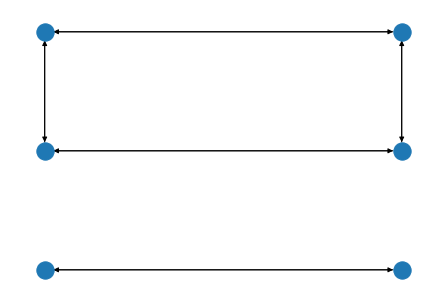

In [26]:
last = getGraph(CCDAmplitudes.summandList[-1])
nx.draw(last, nx.multipartite_layout(last, "vertex", "horizontal"))

In [27]:
with open("CCDEquations.pkl", 'rb') as f:
    up = pickle.Unpickler(f)
    d = up.load()
    energyEquation = d["energyEquation"]
    doublesAmplitudeEquation = d["doublesAmplitudeEquation"]
    fockTensor = d["fockTensor"]
    h2Tensor = d["h2Tensor"]
    t2Tensor = d["t2Tensor"]

In [28]:
print(len(doublesAmplitudeEquation.summandList))
print(doublesAmplitudeEquation)

708
1.0 * v_{p_{1}p_{0}}^{h_{1}h_{0}}
 + -0.5 * v_{p_{0}p_{1}}^{h_{1}h_{0}}
 + -0.5 * v_{p_{1}p_{0}}^{h_{0}h_{1}}
 + 1.0 * v_{p_{0}p_{1}}^{h_{0}h_{1}}
 + 0.5 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{1}}
 + -1.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{1}}
 + -1.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{2}}
 + 0.5 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{1}h_{2}}
 + -1.0 * f_{h_{2}}^{h_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{0}}
 + 0.5 * f_{h_{2}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + 0.5 * f_{h_{2}}^{h_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{0}h_{2}}
 + -1.0 * f_{h_{2}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{2}}
 + -0.5 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{1}h_{0}}
 + 1.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{1}h_{0}}
 + 1.0 * f_{p_{0}}^{p_{3}}{t_{2}}_{p_{1}p_{3}}^{h_{1}h_{0}}
 + -0.5 * f_{p_{0}}^{p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{1}h_{0}}
 + 1.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{0}h_{1}}
 + -0.5 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{0}h_{1}}
 +

In [31]:
collectedDoublesAmplitudeEquation = doublesAmplitudeEquation.collectIsomorphicTerms()
print(collectedDoublesAmplitudeEquation)

1.0 * v_{p_{1}p_{0}}^{h_{1}h_{0}}
 + -2.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{1}}
 + 2.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{1}h_{0}}
 + 1.0 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{3}h_{2}}
 + -1.0 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -1.0 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + -1.0 * v_{h_{2}p_{1}}^{p_{3}h_{0}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + 2.0 * v_{h_{2}p_{1}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + -1.0 * v_{p_{1}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + 2.0 * v_{p_{1}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + -1.0 * v_{p_{1}h_{2}}^{p_{3}h_{0}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -1.0 * v_{p_{1}h_{2}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + 1.0 * v_{p_{1}p_{0}}^{p_{4}p_{5}}{t_{2}}_{p_{5}p_{4}}^{h_{1}h_{0}}
 + 2.0 * v_{h_{2}h_{3}}^{p_{2}p_{3}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}{t_{2}}_{p_{3}p_{2}}^{h_{3}h_{2}}
 + -1.0 * v_{h_{2}h_{3}}^{p_{2}p_{3}

In [32]:
len(collectedDoublesAmplitudeEquation.summandList)

28